In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import numpy as np
from Object_Detection import ObjectDectection
from yolo_helper import GeneratorMultipleOutputs

In [43]:
reduced_dataset_folder = '/home/usuario/repos/Object_Localization/challenge_dataset_v3'
train_folder = reduced_dataset_folder + '/images/train'
val_folder = reduced_dataset_folder + '/images/val'
annotations_dict_train = np.load(reduced_dataset_folder+'/annotations_train.npy').flat[0]
annotations_dict_val = np.load(reduced_dataset_folder+'/annotations_val.npy').flat[0]
classes = list(annotations_dict_train.keys())
print(classes)

['n02165456', 'n02226429', 'n01644373', 'n02279972', 'n01632458', 'n02256656', 'n01774384', 'n01770393']


In [44]:
NUMBER_OF_CLASSES = 8
IMAGE_H = 320
IMAGE_W = 320
GRID_H = IMAGE_H // 32
GRID_W = IMAGE_W // 32
NUMBER_OF_BBOXES = 1
object_detection = ObjectDectection(NUMBER_OF_CLASSES, IMAGE_H, IMAGE_W, NUMBER_OF_BBOXES, ARQUITECTURE='VGG16', trainable_from_layer=0)
model = object_detection.model
model.summary()

Model trainable from layer input_20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 320, 320, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 10, 10, 512)       2048      
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 10, 512)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 10, 13)        6669      
_________________________________________________________________
reshape_9 (Reshape)          (None, 10, 10, 1, 13)     0         
Total params: 14,723,405
Trainable params: 14,722,381
Non-trainable params: 1,024
________________________

In [45]:
batch_size = 60
train_generator = GeneratorMultipleOutputs(annotations_dict_train, 
                            train_folder, batch_size, classes = classes,
                            target_size=(IMAGE_H,IMAGE_W),
                            GRID_H = GRID_H,
                            GRID_W = GRID_W, 
                            flip_horizontal = True, 
                            flip_vertical = True,
                            crop_per=0.2
                           )

Found 2400 images belonging to 8 classes.


In [46]:
val_generator = GeneratorMultipleOutputs(annotations_dict_val, 
                            val_folder, batch_size, classes = classes,
                            target_size=(IMAGE_H,IMAGE_W),
                            GRID_H = GRID_H,
                            GRID_W = GRID_W,
                            flip_horizontal = True, 
                            flip_vertical= True,
                            crop_per=0.2
                           )

Found 480 images belonging to 8 classes.


In [47]:
# model.load_weights('weights_yolo_loss_plus_aumentation_focal_loss.hdf5')

In [48]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, rmsprop, SGD
filename = 'runtime'
checkpoint = ModelCheckpoint(filepath = filename+'_best.hdf5', 
                             monitor='val_classes_acc', save_best_only=True)
model.compile(loss=[
        object_detection.losses.YOLO_loss(k_classes = 1, k_bboxes = 1)], 
              optimizer=Adam(lr=0.0001),
              metrics=[object_detection.metrics.classes_accuracy(), 
                       object_detection.metrics.IOU(), 
                       object_detection.metrics.object_accuracy(),
                       object_detection.metrics.no_object_accuracy(),
                       object_detection.losses.focal_loss(),
                       object_detection.losses.bounding_box_mse(),
                       object_detection.losses.object_bin_cross_entropy_loss(),
                       object_detection.losses.no_object_bin_cross_entropy_loss()
                      ]
             )

In [49]:
from Object_Detection import PlotLosses

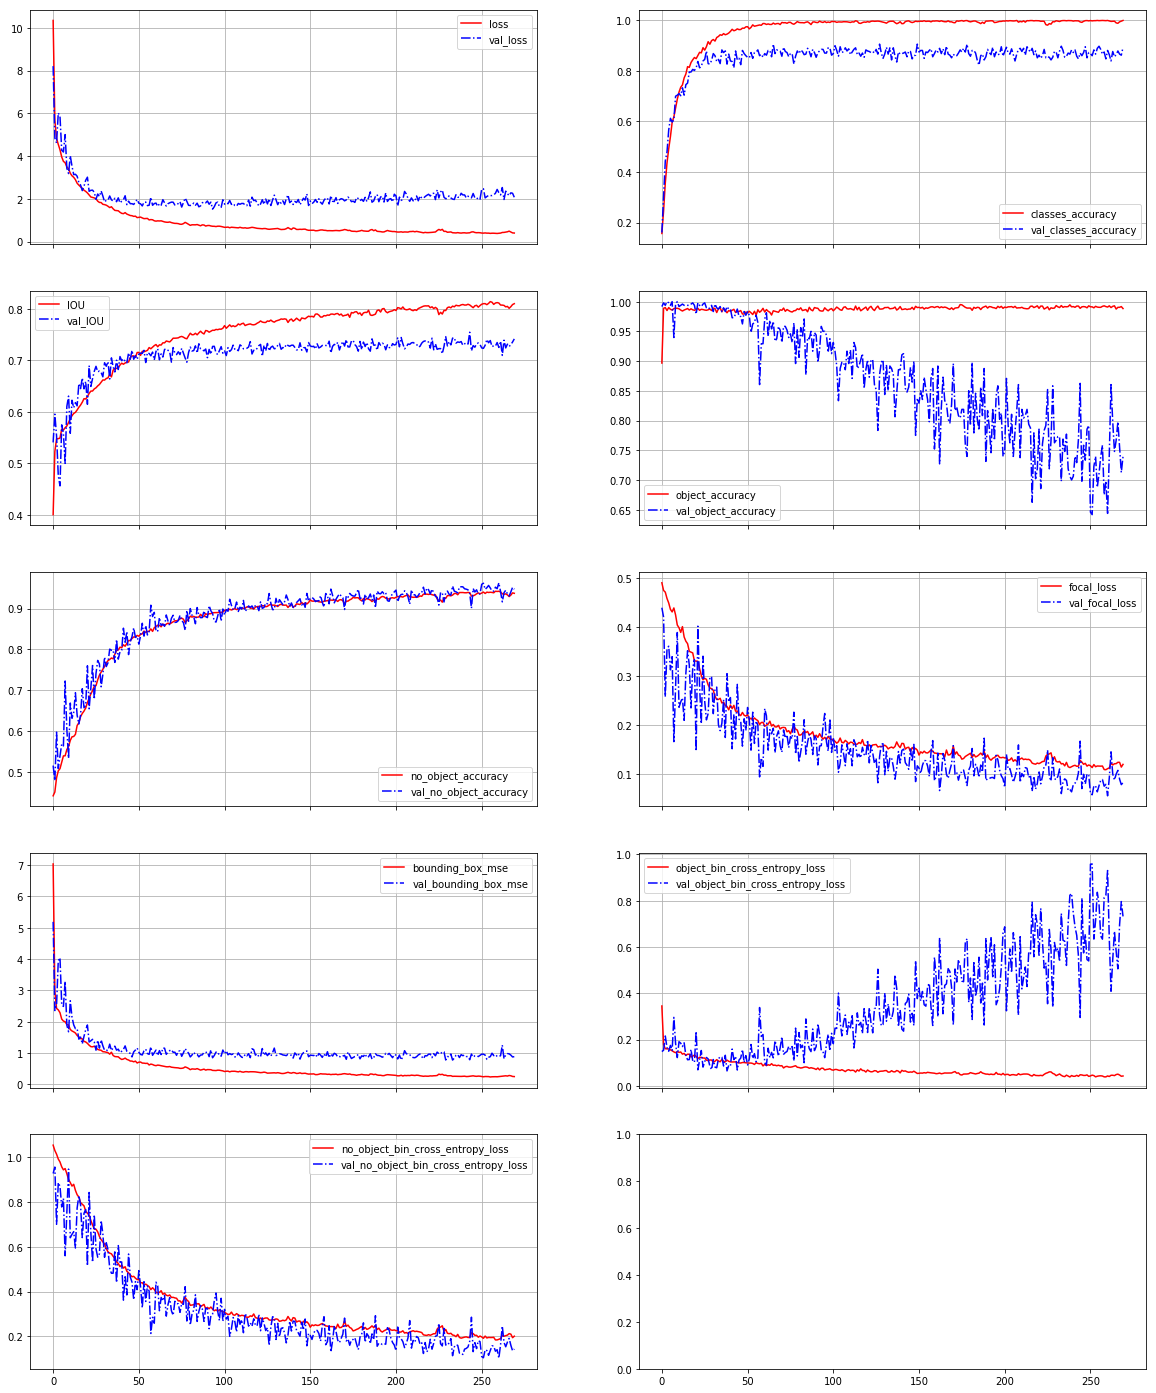

Epoch 271/2000


KeyboardInterrupt: 

In [50]:
plot_losses = PlotLosses(1)
model.fit_generator(
        train_generator,
        epochs=2000,
        validation_data=val_generator,callbacks = [plot_losses]
        )

In [28]:
#model.load_weights('weights_yolo_VGG16.hdf5')
metrics_values = model.evaluate_generator(val_generator)
for i, met in enumerate(metrics_values):
    print(model.metrics_names[i], ':', met)

loss : 2.1518545895814896
classes_accuracy : 0.8500000089406967
IOU : 0.727422297000885
object_accuracy : 0.9416666626930237
no_object_accuracy : 0.9248106107115746
focal_loss : 0.12942794896662235
bounding_box_mse : 0.8277586549520493
object_bin_cross_entropy_loss : 0.13886285480111837
no_object_bin_cross_entropy_loss : 0.22557900846004486


In [21]:
def save_data(model, filename_suffix):
    model.save_weights('weights'+filename_suffix+'.hdf5')
    np.save('history' + filename_suffix, model.history.history)

In [27]:
filename_suffix = '_yolo_VGG16_2'
save_data(model, filename_suffix)